In [26]:
import pandas as pd
import numpy as np
import cv2
from skimage.morphology import skeletonize
from skimage.util import invert
import matplotlib.pyplot as plt
from skimage.morphology import disk, square, erosion, dilation, area_closing, remove_small_objects
import scipy.ndimage as ndi

In [2]:
# first data, read CSV + image
path = '../../Data/'
f_img = cv2.imread(path + 'ex03.jpg')
gray_f_img = cv2.cvtColor(f_img, cv2.COLOR_BGR2GRAY)
f_gt = pd.read_csv(path + 'ex03.csv', header=None)

In [3]:
f_gt

,0,1
0,381.0,1060.0
1,465.0,1374.0
2,546.0,1223.0
3,572.0,938.0
4,583.0,1098.0
5,646.0,1596.0
6,655.0,630.0
7,682.0,670.0
8,727.0,1504.0
9,752.0,1313.0


In [68]:
def plot_img(img, gt, title):
    xs = list(gt[0])
    ys = list(gt[1])
    plt.figure(figsize=(10,8))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    for idx in range(len(xs)):
        j, i = ys[idx], xs[idx]
        plt.scatter(j, i, color='r')
    plt.show()

In [52]:
gray_f_img

array([[111, 112, 114, ..., 124, 123, 123],
       [112, 113, 114, ..., 124, 124, 124],
       [113, 113, 114, ..., 125, 125, 125],
       ...,
       [ 82,  83,  83, ..., 121, 121, 121],
       [ 81,  82,  82, ..., 122, 121, 121],
       [ 81,  82,  81, ..., 122, 121, 121]], dtype=uint8)

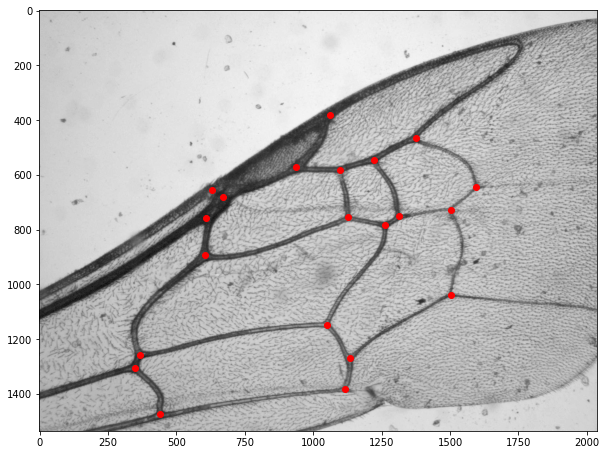

In [53]:
plot_img(gray_f_img, f_gt, title='')

In [7]:
# threshold image
threshold_val = 90
ret, img = cv2.threshold(gray_f_img, threshold_val, 255, 0)

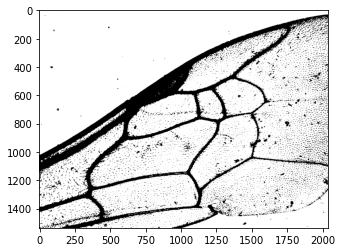

In [8]:
plt.imshow(img, cmap='gray')
plt.show()

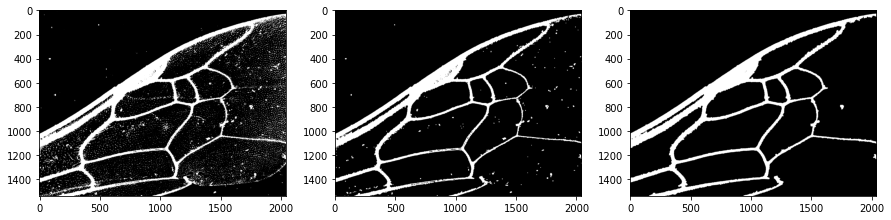

In [9]:
image = invert(img)
plt.figure(figsize=(15,12))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')

tmp = erosion(image, square(5))
tmp = erosion(tmp, square(2))
tmp = dilation(tmp, square(5))

plt.subplot(1, 3, 2)
plt.imshow(tmp, cmap='gray')
tmp = tmp > 0
tmp = remove_small_objects(tmp, min_size=500)
tmp = dilation(tmp, square(5))

plt.subplot(1, 3, 3)
plt.imshow(tmp, cmap='gray')
plt.show()

In [10]:
tmp = tmp.astype(np.float32)
blur = cv2.medianBlur(tmp, 5)

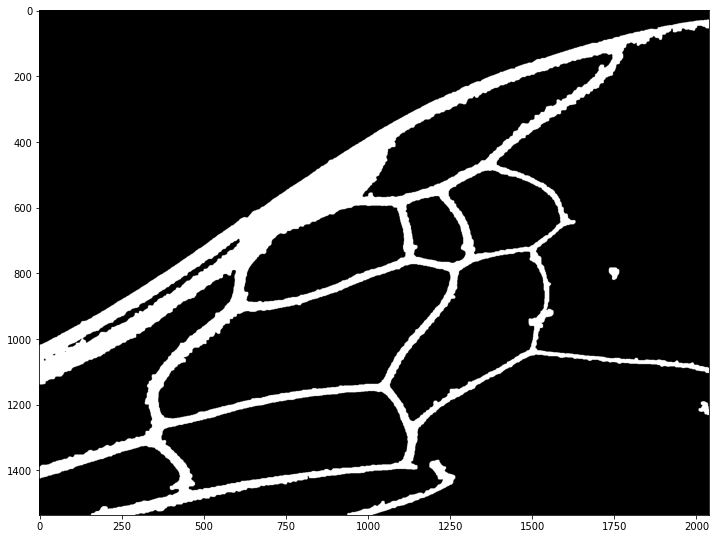

In [11]:
plt.figure(figsize=(12,10))
plt.imshow(blur, cmap='gray')
plt.show()

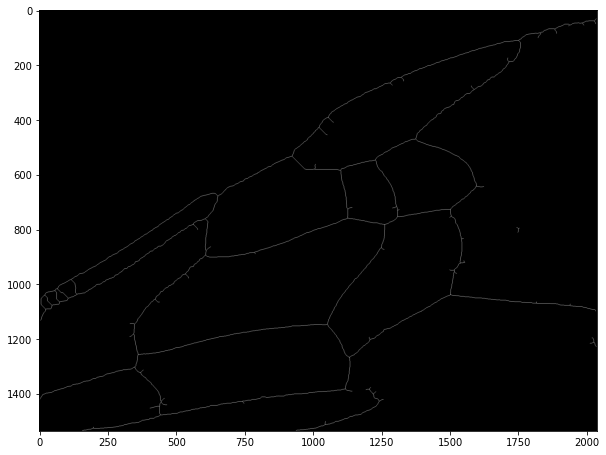

In [35]:
tmp = tmp.astype(np.float32)

# perform skeletonization
skeleton = skeletonize(blur)
plt.figure(figsize=(10,8))
plt.imshow(skeleton, cmap='gray')
plt.show()

In [37]:
branches = np.zeros_like(skeleton, dtype=bool)
branches.shape

(1536, 2039)

In [38]:
selems = list()
selems.append(np.array([[0, 1, 0], [1, 1, 1], [0, 0, 0]]))
selems.append(np.array([[1, 0, 1], [0, 1, 0], [1, 0, 0]]))
selems.append(np.array([[1, 0, 1], [0, 1, 0], [0, 1, 0]]))
selems.append(np.array([[0, 1, 0], [1, 1, 0], [0, 0, 1]]))
selems.append(np.array([[0, 0, 1], [1, 1, 1], [0, 1, 0]]))
selems = [np.rot90(selems[i], k=j) for i in range(5) for j in range(4)]

selems.append(np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]))
selems.append(np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]))

In [39]:
for selem in selems:
    branches |= ndi.binary_hit_or_miss(skeleton, selem)

In [40]:
np.unique(branches)

array([False,  True])

In [45]:
res = np.where(branches == True)
res

(array([  40,   47,   54,   69,   83,  111,  188,  245,  266,  289,  392,
         428,  470,  533,  547,  580,  584,  642,  678,  716,  725,  727,
         731,  752,  753,  759,  761,  782,  782,  797,  834,  867,  876,
         884,  894,  920,  922,  948,  955,  963,  983, 1017, 1024, 1036,
        1038, 1040, 1051, 1055, 1065, 1069, 1077, 1077, 1091, 1146, 1146,
        1182, 1201, 1212, 1256, 1266, 1302, 1322, 1382, 1383, 1400, 1426,
        1426, 1428, 1431, 1445, 1477, 1512, 1525]),
 array([2029, 1985, 1938, 1885, 1832, 1752, 1717, 1323, 1283, 1589, 1057,
        1023, 1376,  924, 1228, 1007, 1101, 1598,  653, 1306, 1128, 1503,
        1310, 1506, 1310, 1128,  607,  563, 1263, 1752, 1544, 1251,  610,
         786,  608, 1553, 1540, 1517, 1518,  535,  117,   67,   58,  138,
        1503,   21,  107,  424,   75, 1817,   47, 1940,   24,  348, 1053,
         345, 1209, 2027,  362, 1134,  350,  371, 1119, 1207, 1221,  446,
        1243,  743,  446,  440,  444, 1045,  198]))

In [46]:
# build pandas datafram
data = {
    0: list(res[0]),
    1: list(res[1])
}
df_res = pd.DataFrame(data)

In [49]:
df_res

,0,1
0,40,2029
1,47,1985
2,54,1938
3,69,1885
4,83,1832
...,...,...
68,1431,446
69,1445,440
70,1477,444
71,1512,1045


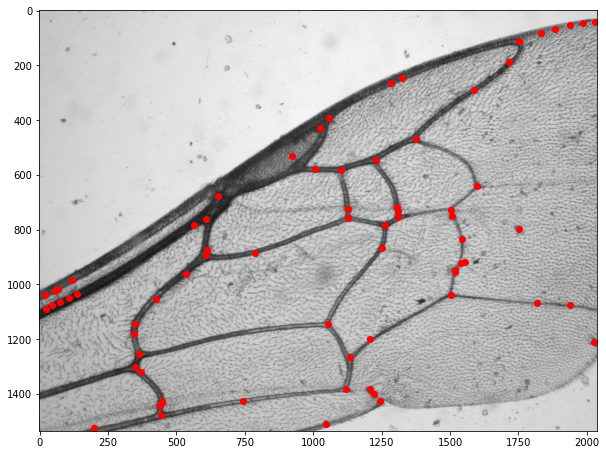

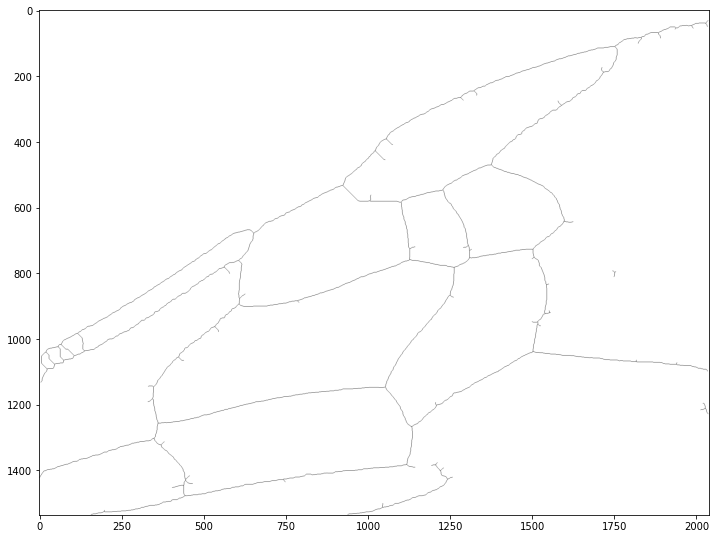

In [70]:
plot_img(gray_f_img, df_res, title='')
plt.figure(figsize=(12,10))
plt.imshow(np.invert(skeleton), cmap='gray')
plt.show()

In [13]:
i, j = list(f_gt.iloc[10])
i, j = int(i), int(j)
i, j

(756, 1128)

In [14]:
skeleton = invert(skeleton)

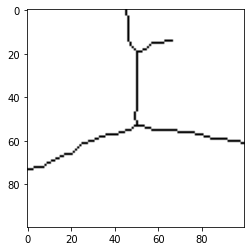

In [15]:
win_size=50
template_1 = skeleton[i-win_size:i+win_size, j-win_size:j+win_size]
plt.imshow(template_1, cmap='gray')
plt.show()

In [16]:
template_1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [17]:
skeleton = skeleton.astype(np.float32)
skeleton

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

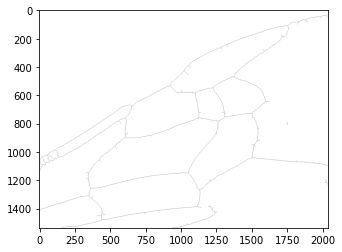

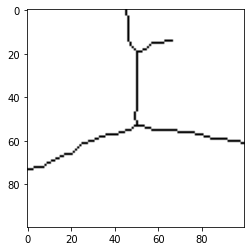

In [18]:
plt.imshow(skeleton, cmap='gray')
plt.show()
plt.imshow(template_1, cmap='gray')
plt.show()

In [19]:
template_1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

None
None


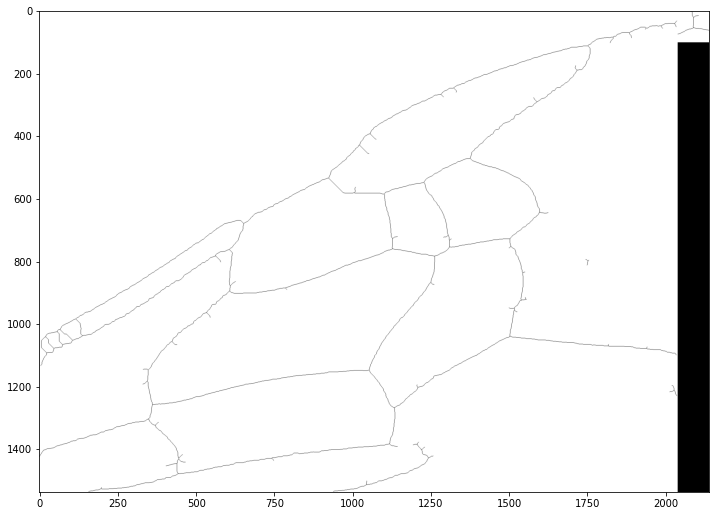

In [332]:

#rgb_skeleton = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
#template = template_1.astype(np.float32)
#template = cv2.cvtColor(template, cv2.COLOR_GRAY2BGR)

# orb = cv2.ORB_create()
# kp1, des1 = orb.detectAndCompute(rgb_skeleton, None)
# kp2, des2 = orb.detectAndCompute(template, None)

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
#rgb_skeleton *= 255.0
rgb_skeleton = rgb_skeleton.astype(np.uint8)
kp1, des1 = sift.detectAndCompute(rgb_skeleton, None)

#template *= 255.0
template = template.astype(np.uint8)
kp2, des2 = sift.detectAndCompute(template, None)

print(des1)
print(des2)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(rgb_skeleton, kp1, template, kp2, good,
                         None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12,10))
plt.imshow(img3)
plt.show()
        
# matches = bf.match(des1, des2)
# matches = sorted(matches, key = lambda x:x.distance)


# img3 = cv2.drawMatches(rgb_skeleton, kp1, template,
#                        kp2, matches[:30], None,
#                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# plt.figure(figsize=(12,10))
# plt.imshow(img3)
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


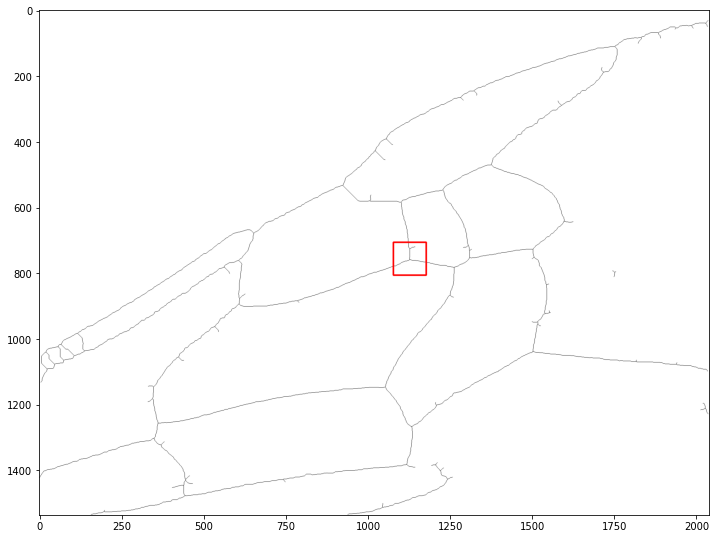

In [311]:
skeleton2 = skeleton.copy()
w = template_1.shape[1]
h = template_1.shape[0]
template = template_1.astype(np.float32)

methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
           'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

method = cv2.TM_CCOEFF_NORMED

img = skeleton2.copy()

# Apply template Matching
res = cv2.matchTemplate(img, template, method)
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR);

threshold = 0.5
loc = np.where(res >= threshold)

for pt in zip(*loc[::-1]):
    cv2.rectangle(output, pt, (pt[0] + w, pt[1] + h), (255, 0, 0), 3)
    
plt.figure(figsize=(12, 10))
plt.imshow(output)
plt.show()

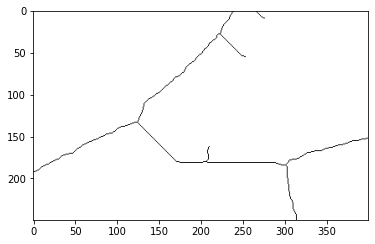

In [281]:
plt.imshow(skeleton2[400:650, 800:1200], cmap='gray')
plt.show()

In [132]:
dst = cv2.cornerHarris(skeleton, blockSize=2, ksize=3, k=0.7)
dst

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

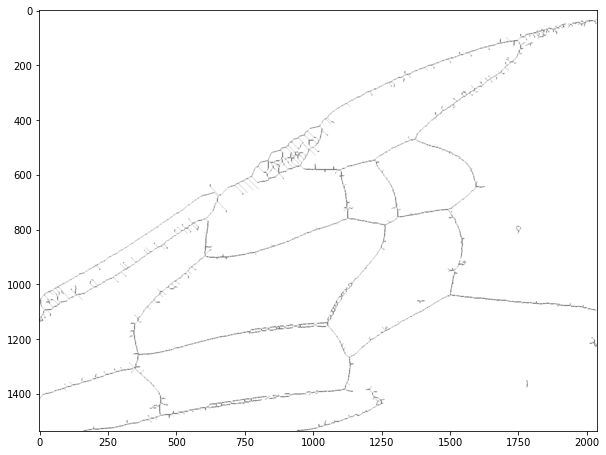

In [145]:
plt.figure(figsize=(10,8))
plt.imshow(dst, cmap='gray')
plt.show()

In [106]:
# try Harris corner detector
#gray_f_img = np.float32(gray_f_img)
gray_f_img.dtype, gray_f_img.shape

(dtype('float32'), (1536, 2048))

In [138]:
dst = cv2.cornerHarris(gray_f_img, blockSize=2, ksize=3, k=0.7)
dst

array([[-1.12879684e+02, -1.12879684e+02, -2.73757801e+01, ...,
        -2.17480451e-01, -5.17578097e-03,  0.00000000e+00],
       [-1.12879684e+02, -1.12879684e+02, -2.73757801e+01, ...,
        -2.17480451e-01, -5.17578097e-03,  0.00000000e+00],
       [-2.31207809e+02, -2.31207809e+02, -1.54988571e+02, ...,
        -2.47851551e-01, -1.75781245e-03,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.59914883e+04, -3.22508047e+04, -3.59540156e+04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.71268398e+04, -1.46771807e+04, -3.10260625e+04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.06891875e+04, -7.87063232e+02, -8.76800781e+02]], dtype=float32)

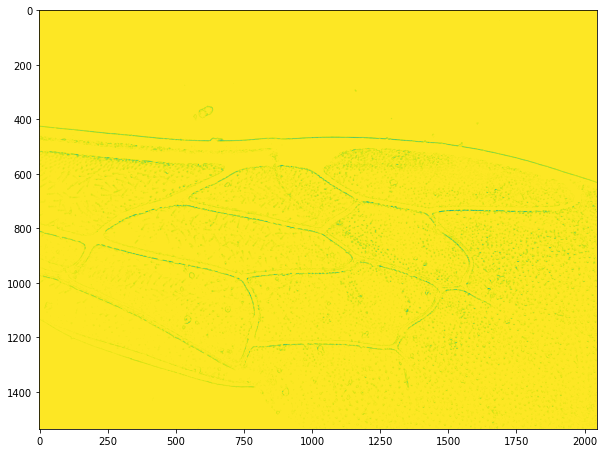

In [140]:
plt.figure(figsize=(10,8))
plt.imshow(dst)

In [141]:
# TODO
# 8-connectivity neighbors
# Skeletonization (cv2.ximgproc.thinning)

# links
# https://answers.opencv.org/question/228131/detection-of-blood-vessels-junctions/
# https://docs.opencv.org/3.4/d1/dc5/tutorial_background_subtraction.html
# https://answers.opencv.org/question/228567/checking-for-numbers-of-blood-vessels-junctions-detected/
# https://github.com/kasturijoshi06/Blood-vessel-extraction-and-microaneurysm-detection-in-retinal-images/blob/master/bloodvesselextraction.py